In [3]:
### If you want to run on Compute Canada
!python3 -m venv ~/venvs/torch
!~/venvs/torch/bin/python -m pip install --upgrade pip
!~/venvs/torch/bin/python -m pip install torch torchvision
!~/venvs/torch/bin/python -m pip install ipykernel
!~/venvs/torch/bin/python -m ipykernel install --user --name torch --display-name "Python (torch)"
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install scipy seaborn joblib

Looking in links: /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo2023/x86-64-v4, /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo2023/x86-64-v3, /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo2023/generic, /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/generic
  Obtaining dependency information for pip from https://files.pythonhosted.org/packages/44/3c/d717024885424591d5376220b5e836c2d5293ce2011523c9de23ff7bf068/pip-25.3-py3-none-any.whl.metadata
  Using cached pip-25.3-py3-none-any.whl.metadata (4.7 kB)
Using cached pip-25.3-py3-none-any.whl (1.8 MB)
  Attempting uninstall: pip
    Found existing installation: pip 23.2.1
    Uninstalling pip-23.2.1:
      Successfully uninstalled pip-23.2.1
Looking in links: /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo2023/x86-64-v4, /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo2023/x86-64-v3, /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo2023/generic, /cvmfs/sof

In [1]:
from dataclasses import dataclass
from types import SimpleNamespace
from typing import Optional, Tuple, Dict
import os, time, math
import numpy as np
import pandas as pd
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import time
import math
import itertools
import ellipse_mean_stable as em

In [2]:
# -----------------------------
# Utilities
# -----------------------------

def set_seed(seed: int, device: str):
    torch.manual_seed(seed)
    if device.startswith("cuda"):
        torch.cuda.manual_seed_all(seed)


def make_spd_cov(d: int, device: str, dtype: torch.dtype, seed: int = 0):
    """Random SPD covariance with moderate conditioning."""
    g = torch.Generator(device=device)
    g.manual_seed(seed)
    B = torch.randn(d,d, generator=g, device=device, dtype=dtype)
    Sigma = (B @ B.T) / d + 0.2 * torch.eye(d, device=device, dtype=dtype)
    return Sigma


def maha_error(mu_hat: torch.Tensor, mu_true: torch.Tensor, Sigma_true: torch.Tensor) -> float:
    """Mahalanobis norm ||mu_hat - mu||_{Sigma^{-1}}."""
    delta = (mu_hat - mu_true).to(Sigma_true.device, Sigma_true.dtype)
    Sinv = torch.linalg.inv(Sigma_true)
    val = delta @ Sinv @ delta
    return float(torch.sqrt(torch.clamp(val, min=0.0)).item())


In [3]:
# Data generators
# -----------------------------
@torch.no_grad()
def sample_gaussian(n, d, mu_true, Sigma_true, device, dtype, seed):
    g = torch.Generator(device=device)
    g.manual_seed(seed)
    L = torch.linalg.cholesky(Sigma_true)
    Z = torch.randn(n, d, generator=g, device=device, dtype=dtype)
    return mu_true.unsqueeze(0) + Z @ L.T

@torch.no_grad()
def sample_skewed(n, d, mu_true, Sigma_true, skew_dir, skew_scale,
                  device, dtype, seed):
    """
    skew_dir   : (d,) direction of skew (unit vector recommended)
    skew_scale : scalar controlling skew strength
    """
    g = torch.Generator(device=device)
    g.manual_seed(seed)

    L = torch.linalg.cholesky(Sigma_true)
    Z = torch.randn(n, d, generator=g, device=device, dtype=dtype)

    # Latent skew variable
    U = torch.randn(n, 1, generator=g, device=device, dtype=dtype)
    skew = skew_scale * torch.relu(U) * skew_dir.view(1, -1)

    X = Z @ L.T + skew
    return mu_true.unsqueeze(0) + X



@torch.no_grad()
def sample_contaminated_gaussian(n, d, mu_true, Sigma_true, device, dtype, seed,
                                eta=0.1, shift_scale=8.0, inflate=3.0):
    """
    Huber contamination: (1-eta) N(mu, Sigma) + eta N(mu + shift, inflate*Sigma).
    shift direction is random but fixed per seed.
    """
    g = torch.Generator(device=device)
    g.manual_seed(seed)

    # clean
    L = torch.linalg.cholesky(Sigma_true)
    Z = torch.randn(n, d, generator=g, device=device, dtype=dtype)
    X_clean = mu_true.unsqueeze(0) + Z @ L.T

    # contam mask
    mask = (torch.rand(n, generator=g, device=device) < eta)
    m = int(mask.sum().item())
    if m == 0:
        return X_clean

    # contamination distribution
    # random shift direction
    v = torch.randn(d, generator=g, device=device, dtype=dtype)
    v = v / torch.linalg.norm(v).clamp_min(1e-12)
    shift = shift_scale * v  # magnitude

    Sigma_cont = inflate * Sigma_true
    Lc = torch.linalg.cholesky(Sigma_cont)
    Zc = torch.randn(m, d, generator=g, device=device, dtype=dtype)
    X_cont = (mu_true + shift).unsqueeze(0) + Zc @ Lc.T

    X = X_clean.clone()
    X[mask] = X_cont
    return X


@torch.no_grad()
def sample_banana(n, d, mu_true, Sigma_true,
                  device, dtype, seed, b=0.2):
    """
    Banana-shaped distribution:
      Start with Y ~ N(0, Sigma_true), then warp:
        X1 = Y1
        X2 = Y2 + b*(Y1^2 - E[Y1^2])
      and keep remaining coords as-is.
    This is strongly non-elliptical (curved level sets).
    """
    g = torch.Generator(device=device)
    g.manual_seed(seed)

    L = torch.linalg.cholesky(Sigma_true)
    Y = torch.randn(n, d, generator=g, device=device, dtype=dtype) @ L.T

    # Warp in first two coordinates
    y1 = Y[:, 0]
    y2 = Y[:, 1]
    # Center the quadratic term so mean stays controlled
    y1_var = torch.var(y1, unbiased=False)
    Y[:, 1] = y2 + b * (y1**2 - y1_var)

    return mu_true.view(1, d) + Y


@torch.no_grad()
def sample_multivariate_t(n, d, mu_true, Sigma_true, device, dtype, seed, df=3.0):
    """
    Multivariate t via scale-mixture:
      X = mu + Z / sqrt(U/df),  Z ~ N(0,Sigma), U ~ ChiSquare(df)
    """
    g = torch.Generator(device=device)
    g.manual_seed(seed)

    L = torch.linalg.cholesky(Sigma_true)
    Z = torch.randn(n, d, generator=g, device=device, dtype=dtype) @ L.T  # N(0,Sigma)

    # Chi-square(df) can be sampled via Gamma(k=df/2, theta=2)
    # U ~ Gamma(df/2, 2)
    U = torch.distributions.Gamma(concentration=df/2.0, rate=0.5).sample((n,)).to(device=device, dtype=dtype)
    scale = torch.sqrt(U / df).clamp_min(1e-12)  # (n,)

    X = mu_true.unsqueeze(0) + Z / scale.unsqueeze(1)
    return X




In [4]:
def random_skew_dir(d, device, dtype, seed):
    g = torch.Generator(device=device)
    g.manual_seed(seed)
    v = torch.randn(d, generator=g, device=device, dtype=dtype)
    return v / torch.norm(v)

def _setting_seed(seed0, rep, n, d, rho, *, dist, R_max=None, beta=None, tau=None, iters=None):
    # Stable integer tags for floats
    rho_tag  = int(round(1e6 * float(rho)))
    R_tag    = 0 if R_max is None else int(round(1e6 * float(R_max)))
    beta_tag = 0 if beta  is None else int(round(1e6 * float(beta)))
    tau_tag  = 0 if tau   is None else int(round(1e6 * float(tau)))
    it_tag   = 0 if iters is None else int(iters)

    # Dist tag (stable across runs)
    dist_tag = sum((i + 1) * ord(c) for i, c in enumerate(str(dist))) % 1_000_000

    # Mix everything into a 32-bit-ish seed
    seed = (
        int(seed0)
        + 1_000_000 * int(rep)
        + 10_000 * int(d)
        + 97 * int(n)
        + 31 * int(rho_tag)
        + 17 * int(dist_tag)
        + 13 * int(R_tag)
        + 11 * int(beta_tag)
        + 7  * int(tau_tag)
        + 5  * int(it_tag)
    )
    return int(seed % 2_147_483_647)  # keep it in a safe int range


In [5]:

def _device():
    return "cuda" if torch.cuda.is_available() else "cpu"

@torch.no_grad()
def generate_data(dist, n, d, device, dtype, seed,
                  eta=0.1, shift_scale=8.0, inflate=3.0,
                  skew_scale=1.0):
    mu_true = torch.ones(d, device=device, dtype=dtype)
    Sigma_true = make_spd_cov(d, device=device, dtype=dtype, seed=seed + 17)

    if dist == "gaussian":
        X = sample_gaussian(n, d, mu_true, Sigma_true, device, dtype, seed)

    elif dist == "contam_gaussian":
        X = sample_contaminated_gaussian(
            n, d, mu_true, Sigma_true,
            device, dtype, seed,
            eta=eta, shift_scale=shift_scale, inflate=inflate
        )

    elif dist == "t3":
        X = sample_multivariate_t(
            n, d, mu_true, Sigma_true,
            device, dtype, seed, df=3.0
        )

    elif dist == "skewed":
        # I want to try something else ,, 
        # g = torch.Generator(device=device)
        # g.manual_seed(seed + 999)
        # v = torch.randn(d, generator=g, device=device, dtype=dtype)
        # v = v / torch.linalg.norm(v).clamp_min(1e-12)
        # X = sample_skewed(
        #     n, d, mu_true, Sigma_true,
        #     skew_dir=v, skew_scale=skew_scale,
        #     device=device, dtype=dtype, seed=seed
        # )
        X = sample_banana(
            n, d, mu_true, Sigma_true,
            device=device, dtype=dtype, seed=seed, b=0.2)
    else:
        raise ValueError(dist)

    return X, mu_true, Sigma_true



def run_simulation_init_sweep(
    init_coef_grid=(0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 2.0, 3.0, 4.0),
    dist_grid=("gaussian", "contam_gaussian", "t3", "skewed"),
    reps=20,
    dtype=torch.float32,
    seed0=1234,
    n_grid=(1000,),
    d_grid=(10,),
    rho_grid=(0.1,),
    # generator params
    eta=0.1, shift_scale=2.0, inflate=3.0, skew_scale=4.0,
    # fixed algorithm params
    R_max_coef=50.0,
    beta=1.01,
    iters=3,
    tau_high=(0.9, 0.9, 0.9),
    tau_low=(0.9, 0.8, 0.6),
    out_path="mh_errors_init_sweep.csv",
):
    device = _device()
    print(f"Running on {device}")

    rows = []

    for n in n_grid:
        for d in d_grid:
            R_max = float(R_max_coef) * math.sqrt(d)

            for rho in rho_grid:
                for dist in dist_grid:
                    print(f"Running init-sweep, n={n}, d={d}, rho={rho}, dist={dist}")

                    for rep in range(reps):
                        # Use a seed that does NOT depend on init, so all inits see the same dataset per rep
                        seed = _setting_seed(seed0, rep, n, d, rho, dist=dist)

                        X, mu_true, Sigma_true = generate_data(
                            dist, n, d, device, dtype, seed,
                            eta, shift_scale, inflate, skew_scale
                        )

                        # baseline 
                        mu_mean = X.mean(dim=0)
                        err_mean = maha_error(mu_mean, mu_true, Sigma_true)

                        for c in init_coef_grid:
                            init = float(c) * torch.ones(d, device=device, dtype=dtype)

                            # ---- Private ellipse (high-τ)
                            try:
                                mu_ell = em.private_ellipse_iteration(
                                    X,
                                    rho_total=float(rho),
                                    r=R_max,
                                    iters=iters,
                                    init=init,
                                    R_min=1.0,
                                    R_max=R_max,
                                    thresholds=tuple(tau_high[:iters]),
                                    beta=beta,
                                    Sigma_unknown=False,
                                    Sigma=Sigma_true,
                                    max_iter=100000,
                                )
                                err_ell = maha_error(mu_ell, mu_true, Sigma_true)
                            except Exception:
                                err_ell = float("nan")

                            # ---- Private ellipse (low-τ / robust)
                            try:
                                mu_ell_rob_out = em.private_ellipse_iteration(
                                    X,
                                    rho_total=float(rho),
                                    r=R_max,
                                    iters=iters,
                                    init=init,
                                    R_min=1.0,
                                    R_max=R_max,
                                    thresholds=tuple(tau_low[:iters]),
                                    beta=beta,
                                    Sigma_unknown=False,
                                    Sigma=Sigma_true,
                                    max_iter=100000,
                                )
                                err_ell_rob = maha_error(mu_ell_rob_out, mu_true, Sigma_true)
                            except Exception:
                                err_ell_rob = float("nan")

                            rows.append({
                                "dist": dist,
                                "n": int(n),
                                "d": int(d),
                                "rep": int(rep),
                                "rho": float(rho),

                                # 
                                "init_coef": float(c),

                                #
                                "init_maha_to_true": float(maha_error(init, mu_true, Sigma_true)),

                                # errors
                                "mh_mean": float(err_mean),
                                "mh_ellipse": float(err_ell),
                                "mh_ellipse_rob": float(err_ell_rob),

                                # fixed settings 
                                "eta": float(eta),
                                "R_max": float(R_max),
                                "R_max_coef": float(R_max_coef),
                                "beta": float(beta),
                                "iterations": int(iters),
                                "tau_high_1": float(tau_high[0]),
                                "tau_high_2": float(tau_high[1]),
                                "tau_high_3": float(tau_high[2]),
                                "tau_low_1": float(tau_low[0]),
                                "tau_low_2": float(tau_low[1]),
                                "tau_low_3": float(tau_low[2]),
                            })

    df = pd.DataFrame(rows)
    df.to_csv(out_path, index=False)
    print(f"Saved {len(df)} rows to {out_path}")
    return df


In [6]:
d_grid = [5, 20, 100]
n_grid = [500,  2000]
rho_grid= [0.1,1]
df=run_simulation_init_sweep(    init_coef_grid=(1.0,1.5, 2.0, 4.0,10.0),
    reps=200,
    n_grid=n_grid,
    d_grid=d_grid,
    rho_grid=rho_grid,
    out_path="mh_errors_init_200.csv"
)

Running on cuda
Running init-sweep, n=500, d=5, rho=0.1, dist=gaussian
Running init-sweep, n=500, d=5, rho=0.1, dist=contam_gaussian
Running init-sweep, n=500, d=5, rho=0.1, dist=t3
Running init-sweep, n=500, d=5, rho=0.1, dist=skewed
Running init-sweep, n=500, d=5, rho=1, dist=gaussian
Running init-sweep, n=500, d=5, rho=1, dist=contam_gaussian
Running init-sweep, n=500, d=5, rho=1, dist=t3
Running init-sweep, n=500, d=5, rho=1, dist=skewed
Running init-sweep, n=500, d=20, rho=0.1, dist=gaussian
Running init-sweep, n=500, d=20, rho=0.1, dist=contam_gaussian
Running init-sweep, n=500, d=20, rho=0.1, dist=t3
Running init-sweep, n=500, d=20, rho=0.1, dist=skewed
Running init-sweep, n=500, d=20, rho=1, dist=gaussian
Running init-sweep, n=500, d=20, rho=1, dist=contam_gaussian
Running init-sweep, n=500, d=20, rho=1, dist=t3
Running init-sweep, n=500, d=20, rho=1, dist=skewed
Running init-sweep, n=500, d=100, rho=0.1, dist=gaussian
Running init-sweep, n=500, d=100, rho=0.1, dist=contam_gaus

In [10]:


def prep_df_for_plots(df: pd.DataFrame) -> pd.DataFrame:
    dist_map = {
        "gaussian": "Gaussian",
        "contam_gaussian": "Contam. Gaussian",
        "skewed": "Banana-shaped",
        "t3": r"$t_3$"
    }

    df = df.copy()

    # rename to your paper conventions (only if present)
    rename_map = {
        "rho": "ρ",
        "mh_mean": "Sample mean",
        "mh_ellipse": "Balloon mean (high τ)",
        "mh_ellipse_rob": "Balloon mean (low τ)",
        "mh_coinpress": "Coinpress",
        "tau": "τ",
        "R_max": r"$\tilde R_{0}$",
        "beta": r"$\beta$",
        "eta": r"$\eta$",
        "iterations": r"$M$",
    }
    df = df.rename(columns={k: v for k, v in rename_map.items() if k in df.columns})

    # dist pretty names
    if "dist" in df.columns:
        df["dist"] = df["dist"].replace(dist_map)

    return df


In [11]:
def plot_init_sweep_panels_separate_x(df, out_dir="plots", ci=95, show=False):
    os.makedirs(out_dir, exist_ok=True)

    df = prep_df_for_plots(df)

    df["ρ"] = df["ρ"].astype(str)

    ycols = ["Balloon mean (high τ)", "Balloon mean (low τ)"]
    long = df.melt(
        id_vars=["dist", "d", "ρ", "n", "init_coef", "init_maha_to_true"],
        value_vars=ycols,
        var_name="estimator",
        value_name="mh_error",
    ).dropna(subset=["mh_error"])

    for n in sorted(long["n"].unique()):
        dat = long[long["n"] == n].copy()
        dat = dat.sort_values(["d", "dist", "ρ", "init_coef"])

        sns.set_theme(style="whitegrid")

        g = sns.relplot(
            data=dat,
            x="init_coef",            
            y="mh_error",
            hue="estimator",
            style="ρ",
            markers=False,
            dashes=True,
            kind="line",
            row="d",
            col="dist",
            errorbar=("ci", ci),
            linewidth=2,
            facet_kws={"sharex": False, "sharey": False},   
        )

        # Titles/labels
        # g.set_axis_labels(r"$|\tilde\mu_0-\mu|_{\Sigma}$", "Average Mahalanobis error")
        g.set_axis_labels(r"$c$" +"\n" + r"$\tilde\mu_0=c\mu$", "Average Mahalanobis error")
        g.set_titles(row_template="d = {row_name}", col_template="{col_name}")
        g.fig.suptitle(f"(n = {n})", y=1.02)

        outpath = os.path.join(out_dir, f"init_sweep_mahaTicks_n{n}.png")
        g.fig.savefig(outpath, dpi=300, bbox_inches="tight")

        if show:
            plt.show()
        else:
            plt.close(g.fig)

        print(f"Saved: {outpath}")

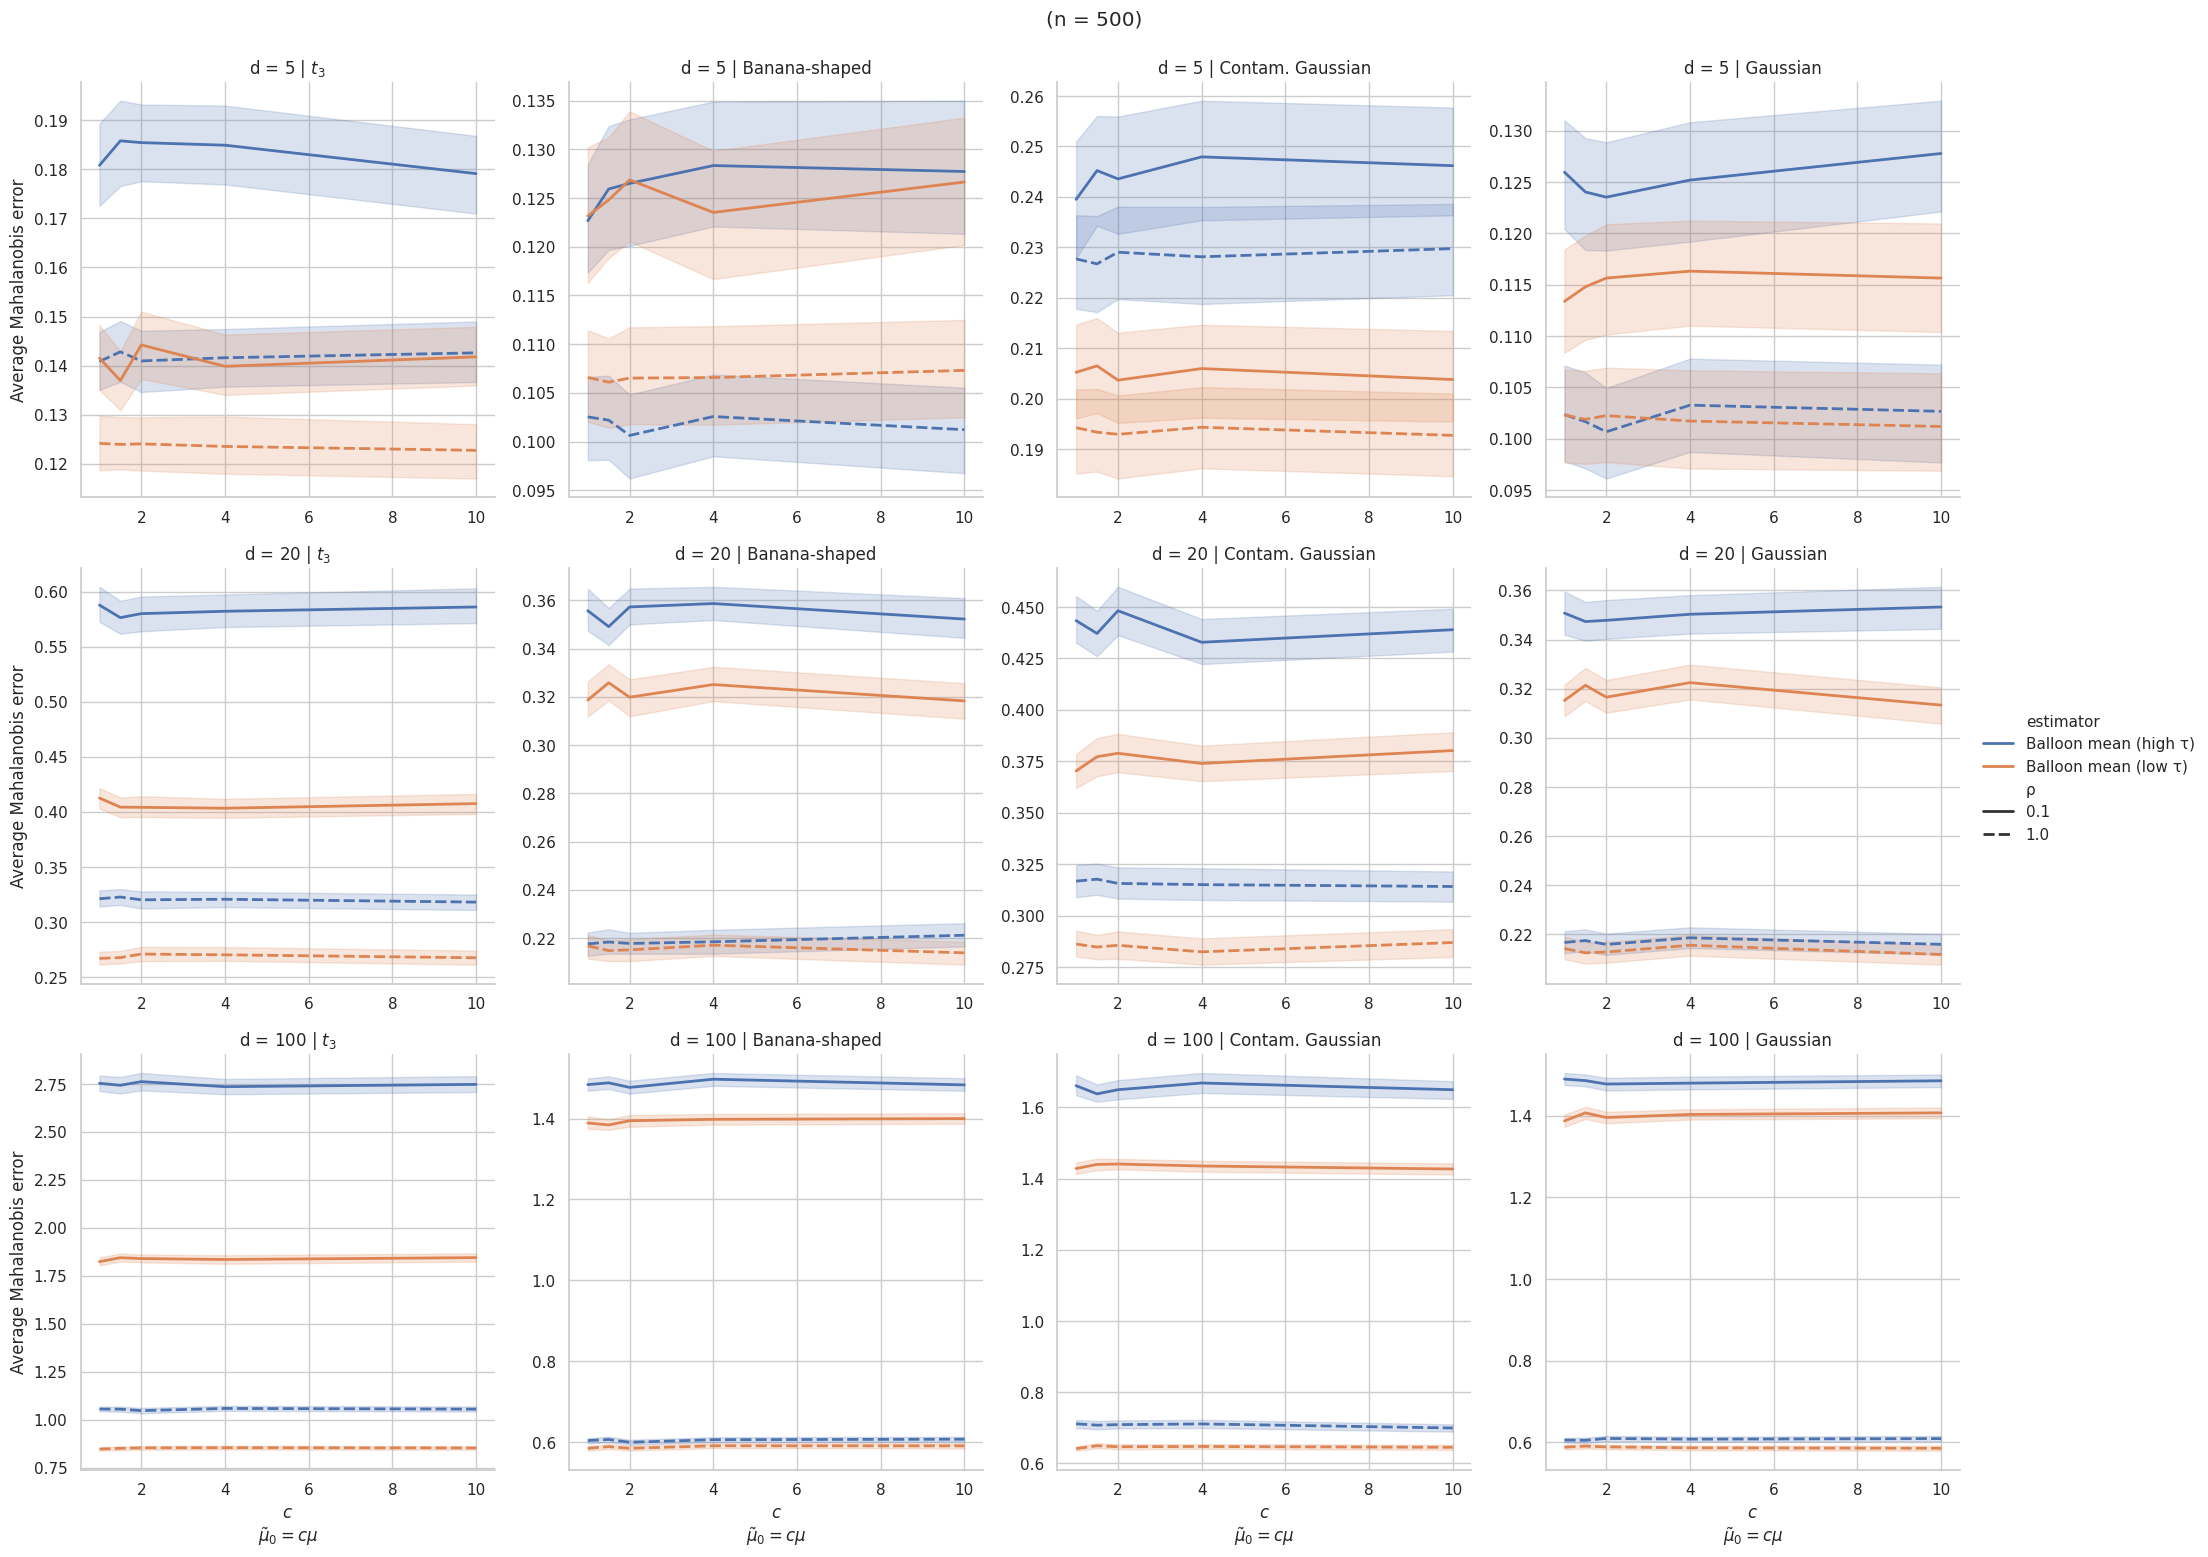

Saved: plots/init_sweep_mahaTicks_n500.png


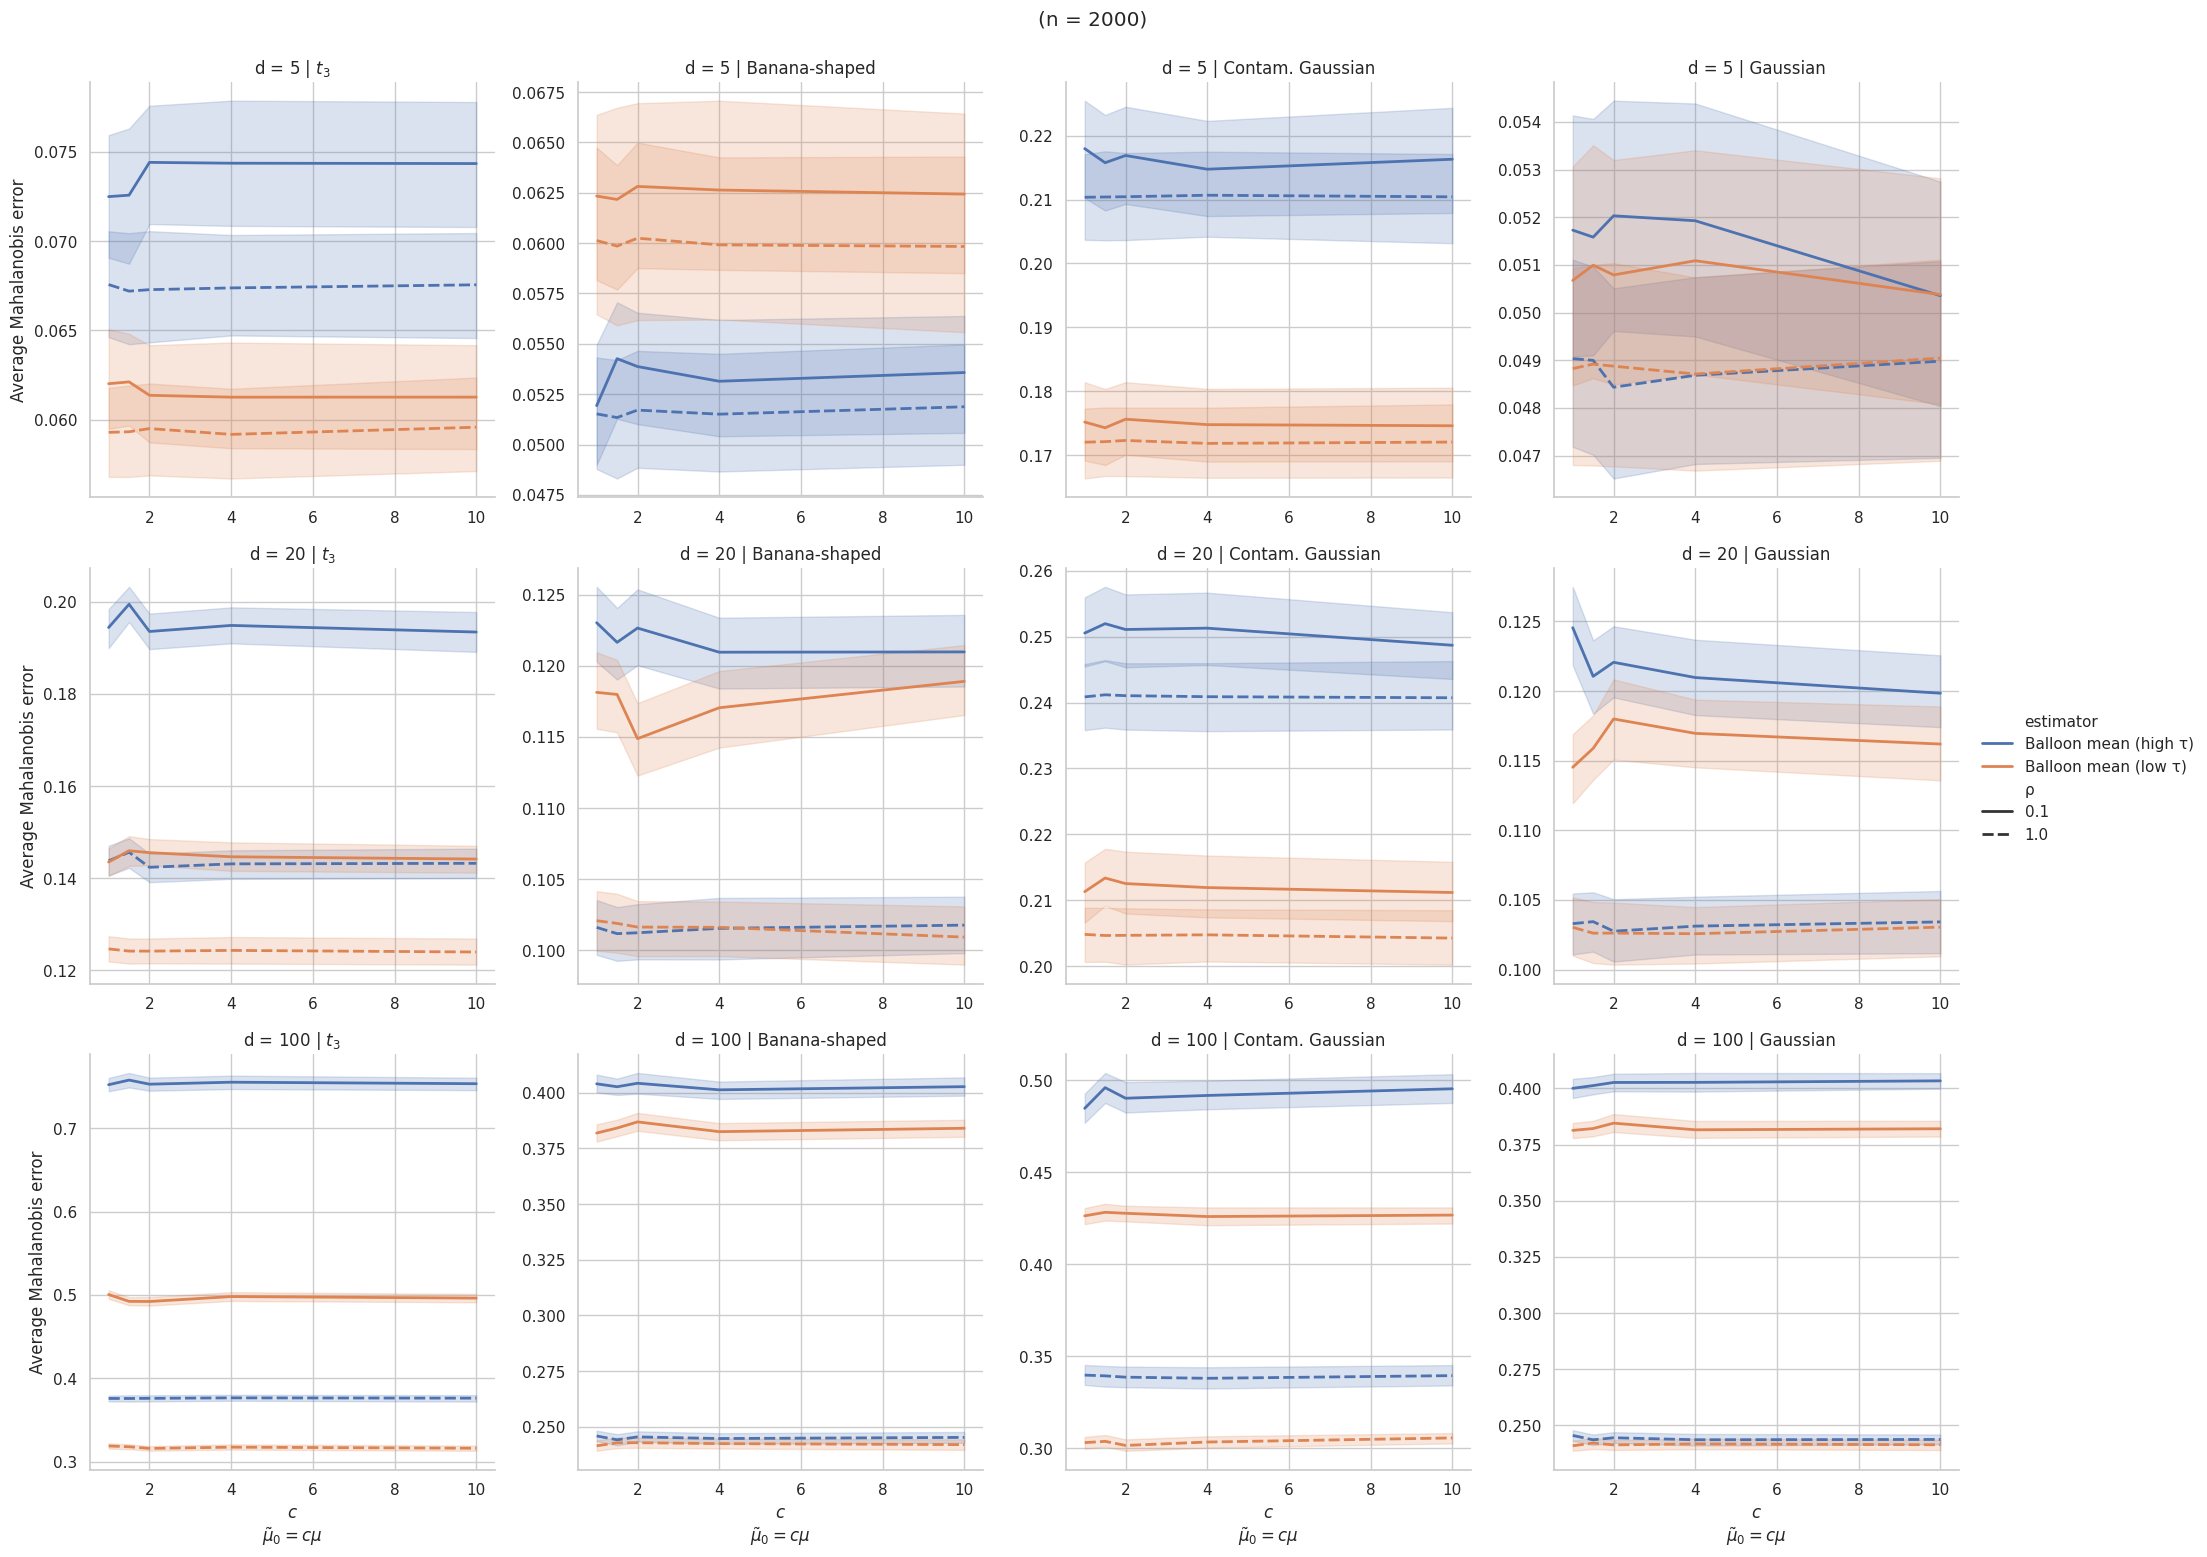

Saved: plots/init_sweep_mahaTicks_n2000.png


In [12]:
df = pd.read_csv("mh_errors_init_200.csv")
plot_init_sweep_panels_separate_x(df, out_dir="plots", show=True)
